In [46]:
#Load the modules for data manipulation.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Load the modules for visualizing NYC.
import geopandas as gpd
from shapely.geometry import Point
import descartes

#Adjust visualization settings.
sns.set()
%matplotlib inline

In [47]:
#Load the output from 'Trend Analysis - Retrieving Yelp Data' notebook.
shops = pd.read_csv('shops.csv')

#Load the Shapefile for NYC into a dataframe. The Shapefile is used to visualize NYC, and was retrieved from NYC Open Data. 
street_map = gpd.read_file('geo_export_629b3182-5516-4755-987b-f4106c7d8b99.shp')

#Omit the first column (which merely duplicates the row indices).
shops = shops.iloc[:,1:]

#The price variable is categorical with levels '$', '$$', '$$$' and '$$$$', as well as missing and irrelevant values.
#To avoid future technical complications, the above levels will be replaced with 'x', 'xx', 'xxx' and 'xxxx' respectively.
for i in range(shops.shape[0]):
    if shops.loc[i,'price'] == '$':
        shops.loc[i,'price'] = 'x'
    elif shops.loc[i,'price'] == '$$':
        shops.loc[i,'price'] = 'xx'
    elif shops.loc[i,'price'] == '$$$':
        shops.loc[i,'price'] = 'xxx'
    elif shops.loc[i,'price'] == '$$$$':
        shops.loc[i,'price'] = 'xxxx'

#Retain only the rows with appropriate price values.
shops = shops[(shops['price'] == 'x') |\
              (shops['price'] == 'xx') |\
              (shops['price'] == 'xxx') |\
              (shops['price'] == 'xxxx')]

#Reset the row indices of shops: 0,1,2,...
shops.index = list(range(shops.shape[0]))

#Dunkin' Donuts appears under two different names, which will be fixed now.
shops.loc[shops['name'] == "Dunkin Donuts", 'name'] = "Dunkin' Donuts"

In [19]:
#Function which restricts shops by the number of reviews
def reviews_range(df, minimum, maximum):
    """
    Returns the sub-dataframe of df such that minimum <= review_count <= maximum.
    """
    return df[df['review_count'].between(minimum, maximum)]

#Function which adds a small amount of random noise to a list of numeric values
def random_jitter(L):
    standard_deviation = .01*(max(L)-min(L))
    return L + np.random.randn(len(L))*standard_deviation

#Function for building Geopandas dataframe with points to be plotted on the map of NYC
def geopandas_dataframe(df):
    """
    df is a dataframe with 'longitude' and 'latitude' columns.
    """
    coordinates_reference_system = {'init': 'epsg:4326'}
    coordinates_dataframe = df[['longitude', 'latitude']]
    geometry = [Point(df.iloc[i]['longitude'], df.iloc[i]['latitude']) for i in range(df.shape[0])]
    return gpd.GeoDataFrame(coordinates_dataframe, crs = coordinates_reference_system, geometry = geometry)

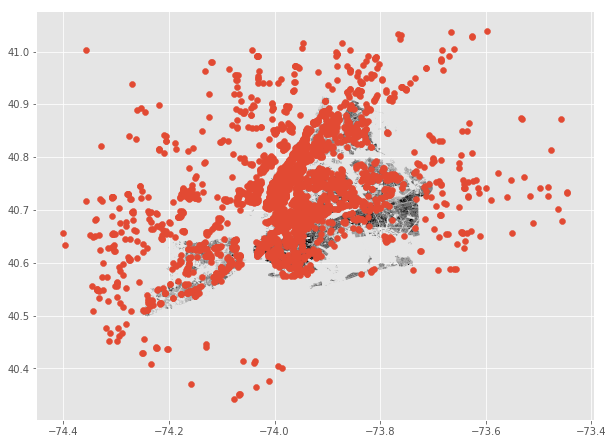

In [11]:
#streetmap.plot() displays a map of NYC; geo_df.plot() displays a point at the location of each shop.
geo_df = geopandas_dataframe(shops)
fig, ax = plt.subplots(figsize=(10,10))
street_map.plot(ax=ax, alpha=1, color='black')
geo_df.plot(ax=ax);

Given that we are only interested in NYC coffee shops, the visualization above reveals many points that do not belong in the dataset. Any point which satisfies at least one of the following three bullets needs to be removed: <br /> <br />
•The longitude is outside of NYC's longitude range (which can be removed used a longitude filter). <br />
•The latitude is outside of NYC's latitude range (which can be removed used a latitude filter). <br />
•The coordinates are within NYC's longitude/latitude ranges but the point is not in NYC (which can be removed using appropriately-chosen rectangles).

In [42]:
#Estimates for the longitude and latitude ranges of NYC, taken directly from Google Maps
min_longitude_NYC = -74.255610
max_longitude_NYC = -73.700049
min_latitude_NYC = 40.496165
max_latitude_NYC = 40.915577

#Repeated application of the following functions will remove the points described in the third bullet above.
def remove_north_west_rectangle(df, corner_lat, corner_lon):
    """
    df is a dataframe with 'longitude' and 'latitude' columns.
    All points that are north-west of (corner_lat, corner_lon) will be filtered out of df.
    """
    return df[~((df['longitude']<corner_lon) & (df['latitude']>corner_lat))]

def remove_north_east_rectangle(df, corner_lat, corner_lon):
    """
    df is a dataframe with 'longitude' and 'latitude' columns.
    All points that are north-east of (corner_lat, corner_lon) will be filtered out of df.
    """
    return df[~((df['longitude']>corner_lon) & (df['latitude']>corner_lat))]

def remove_south_east_rectangle(df, corner_lat, corner_lon):
    """
    df is a dataframe with 'longitude' and 'latitude' columns.
    All points that are south-east of (corner_lat, corner_lon) will be filtered out of df.
    """
    return df[~((df['longitude']>corner_lon) & (df['latitude']<corner_lat))]

#Lists of coordinates that will be used as inputs for remove_north_west_rectangle(), remove_north_east_rectangle() and remove_south_east_rectangle().
#The coordinates were selected directly from Google Maps in such a way that no points in NYC are removed.
north_west_rectangle_corner = [(40.652578, -74.027496), (40.647619, -74.114938), (40.685464, -74.028357),
                               (40.707065, -74.020988), (40.739028, -74.013958), (40.757455, -74.010169),
                               (40.774145, -73.996326), (40.799351, -73.980336), (40.817706, -73.967623), 
                               (40.838019, -73.951854), (40.857452, -73.942018), (40.882348, -73.929711),
                               (40.908047, -73.916567), (40.910700, -73.890578), (40.800000, -73.970000), 
                               (40.560000, -74.200000)]
north_east_rectangle_corner = [(40.905783, -73.882172), (40.891769, -73.834559), (40.879946, -73.789872), 
                               (40.857882, -73.779249), (40.781774, -73.759754), (40.764539, -73.723468)]
south_east_rectangle_corner = [(40.720591, -73.725117), (40.644738, -73.739240), (40.737579, -73.700744),
                               (40.731155, -73.704537), (40.731099, -73.704888), (40.729896, -73.705880),
                               (40.728241, -73.706477)]

In [48]:
#Remove points where the longitude falls outside of the longitude range of NYC or the latitude falls outside of the latitude range of NYC.
shops = shops[shops['longitude'].between(min_longitude_NYC, max_longitude_NYC) &\
              shops['latitude'].between(min_latitude_NYC, max_latitude_NYC)]

#Remove rectangles of points within the longitude/latitude ranges of NYC which are not in NYC.
for (lat, lon) in north_west_rectangle_corner:
    shops = remove_north_west_rectangle(shops, lat, lon)
for (lat, lon) in north_east_rectangle_corner:
    shops = remove_north_east_rectangle(shops, lat, lon)
for (lat, lon) in south_east_rectangle_corner:
    shops = remove_south_east_rectangle(shops, lat, lon)

#Reset the row indices of shops: 0,1,2,...
shops.index = list(range(shops.shape[0]))

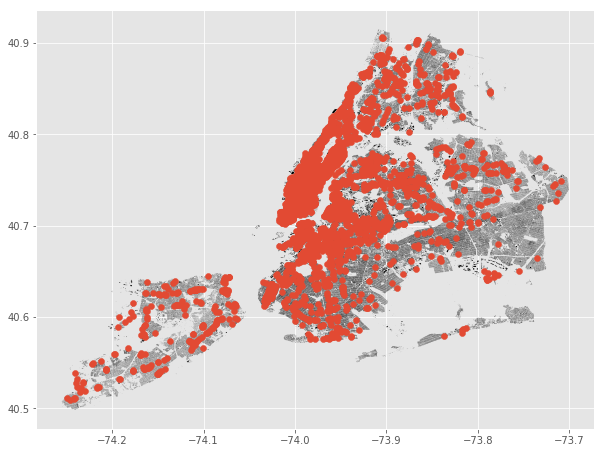

In [22]:
#Create the updated map.
geo_df = geopandas_dataframe(shops)
fig, ax = plt.subplots(figsize=(10,10))
street_map.plot(ax=ax, alpha=1, color='black')
geo_df.plot(ax=ax);

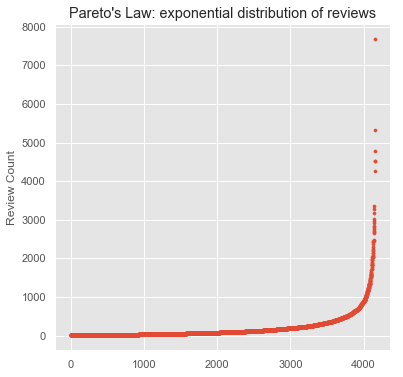

In [366]:
#Visualizing review_count in increasing order.

review_count_sorted = shops['review_count'].sort_values()
number_reviews = len(review_count_sorted)
#Set the indices for the points: 0,1,2...
indices = list(range(number_reviews))

fig, ax = plt.subplots(figsize = (6,6))
plt.scatter(indices, review_count_sorted, s=10)
plt.ylabel('Review Count')
plt.title("Pareto's Law: exponential distribution of reviews");

In [88]:
#Pareto's Law: the lowest 80% of shops by review_count contribute 31% of the total review count across all shops.
shops_lowest_80 = review_count_sorted[:int(0.8*number_reviews)]
shops_highest_20 = review_count_sorted[int(0.8*number_reviews):]
sum(shops_lowest_80) / (sum(shops_highest_20) + sum(shops_lowest_80))

0.3123565948473035

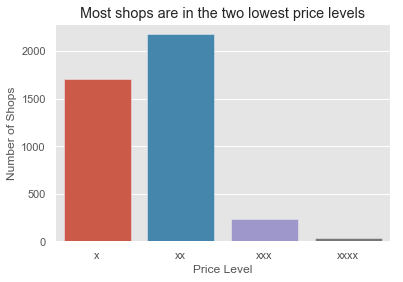

In [208]:
#Univariate analysis of 'price'
price_counts = shops['price'].value_counts()
price_counts_df = pd.DataFrame({'price':price_counts.index, 'count':price_counts.values})

ax = sns.barplot(x='price', y='count', data=price_counts_df, order=['x','xx','xxx','xxxx'])
ax.set(xlabel='Price Level', ylabel='Number of Shops', title="Most shops are in the two lowest price levels")
plt.show()

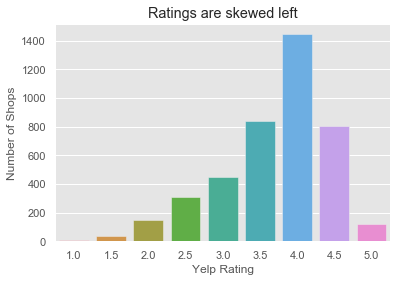

In [427]:
#Univariate analysis of 'rating'
rating_counts = shops['rating'].value_counts()
rating_counts_df = pd.DataFrame({'rating':rating_counts.index, 'count':rating_counts.values})

ax = sns.barplot(x='rating', y='count', data=rating_counts_df)
ax.set(xlabel='Yelp Rating', ylabel='Number of Shops', title="Ratings are skewed left")
plt.show()

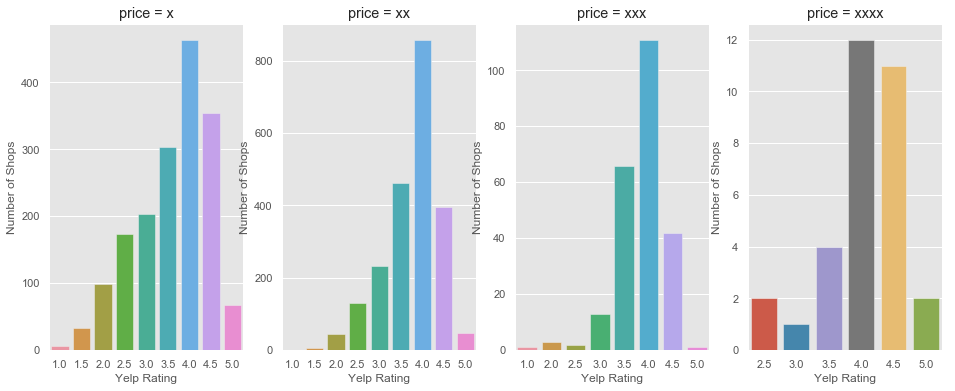

In [428]:
#Compare rating counts by price group

#Define the relevant dataframes to be used in sns.barplot()
rating_counts_x = shops[shops['price']=='x']['rating'].value_counts()
rating_counts_x_df = pd.DataFrame({'rating':rating_counts_x.index, 'count':rating_counts_x.values})
rating_counts_xx = shops[shops['price']=='xx']['rating'].value_counts()
rating_counts_xx_df = pd.DataFrame({'rating':rating_counts_xx.index, 'count':rating_counts_xx.values})
rating_counts_xxx = shops[shops['price']=='xxx']['rating'].value_counts()
rating_counts_xxx_df = pd.DataFrame({'rating':rating_counts_xxx.index, 'count':rating_counts_xxx.values})
rating_counts_xxxx = shops[shops['price']=='xxxx']['rating'].value_counts()
rating_counts_xxxx_df = pd.DataFrame({'rating':rating_counts_xxxx.index, 'count':rating_counts_xxxx.values})

fig, ax = plt.subplots(1,4,figsize=(16,6))
sns.barplot(x='rating', y='count', data=rating_counts_x_df, ax=ax[0])
sns.barplot(x='rating', y='count', data=rating_counts_xx_df, ax=ax[1])
sns.barplot(x='rating', y='count', data=rating_counts_xxx_df, ax=ax[2])
sns.barplot(x='rating', y='count', data=rating_counts_xxxx_df, ax=ax[3])

ax[0].set(xlabel='Yelp Rating', ylabel="Number of Shops", title='price = x')
ax[1].set(xlabel='Yelp Rating', ylabel="Number of Shops", title='price = xx');
ax[2].set(xlabel='Yelp Rating', ylabel="Number of Shops", title='price = xxx');
ax[3].set(xlabel='Yelp Rating', ylabel="Number of Shops", title='price = xxxx');

Discuss the differences in the distributions across price groups; as we proceed to the right the graphs become increasingly left-skewed. 

These graphs suggest that price and rating are positively correlated. This helps justify our choice to build a simulator where more expensive shops tend to be more likely to adopt, and higher-rated shops are more likelt to adopt. If we instead saw a negative correlation above we would have to question the validity of this approach.

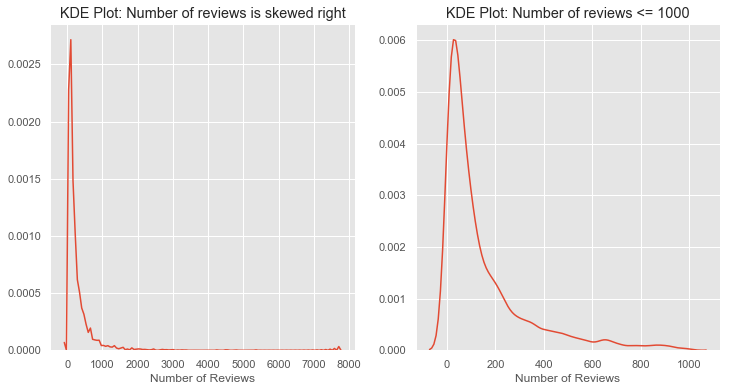

In [253]:
#Univariate analysis of review_count
shops_review_count_1_1000 = reviews_range(shops, 1, 1000)
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.kdeplot(shops['review_count'], ax=ax[0], legend=False)
sns.kdeplot(shops_review_count_1_1000['review_count'], ax=ax[1], legend=False)
ax[0].set(xlabel='Number of Reviews', title='KDE Plot: Number of reviews is skewed right')
ax[1].set(xlabel='Number of Reviews', title='KDE Plot: Number of reviews <= 1000');

In [251]:
#Summary statistics for the distribution of reviews
shops['review_count'].describe().astype(int)

count    4155
mean      198
std       376
min         1
25%        30
50%        81
75%       210
max      7686
Name: review_count, dtype: int32

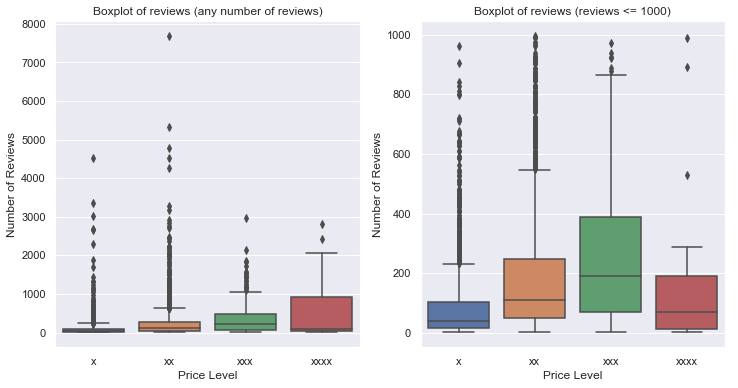

In [613]:
#Bivariate analysis of review_count by price
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.boxplot(x='price', y='review_count', data=shops, ax=ax[0], order=['x','xx','xxx','xxxx'])
sns.boxplot(x='price', y='review_count', data=reviews_range(shops,1,1000), ax=ax[1], order=['x','xx','xxx','xxxx'])
ax[0].set(xlabel='Price Level', ylabel="Number of Reviews", title='Boxplot of reviews (any number of reviews)')
ax[1].set(xlabel='Price Level', ylabel="Number of Reviews", title='Boxplot of reviews (reviews <= 1000)');

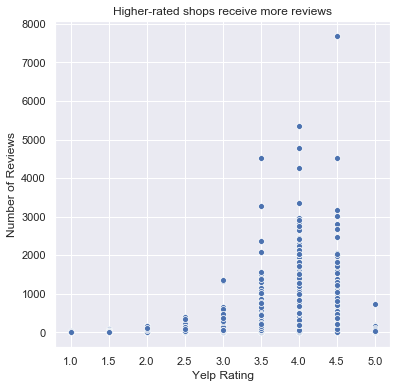

In [612]:
#Bivariate analysis of review_count by rating
fig, ax = plt.subplots(1, figsize=(6,6))
sns.scatterplot(x='rating', y='review_count', data=shops)
ax.set(xlabel='Yelp Rating', ylabel="Number of Reviews", title='Higher-rated shops receive more reviews');

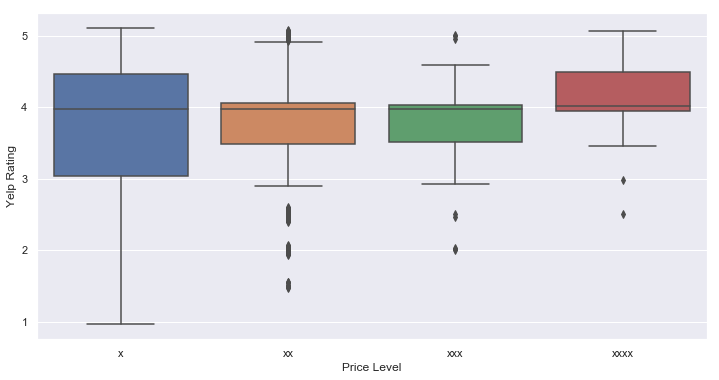

In [11]:
#Bivariate analysis of rating by price
shops_rating_jittered = shops
shops_rating_jittered['rating'] = random_jitter(shops_rating_jittered['rating'])
shops_rating_jittered 

fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x='price', y='rating', data=shops_rating_jittered,  order=['x','xx','xxx','xxxx'])
ax.set(xlabel='Price Level', ylabel='Yelp Rating', title='');

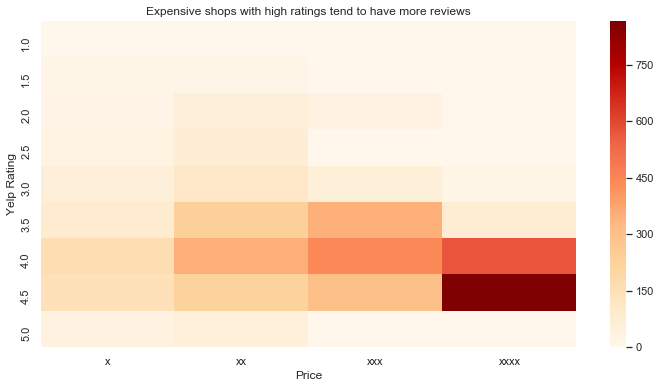

In [635]:
#Creating a heatmap which displays average review_count of shops grouped by rating and price.

#Build 9x4 dataframe where each row corresponds to a rating and each column corresponds to a price.
review_count_heatmap_df = pd.DataFrame({'rating':[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]*4,
                                        'price': ['x']*9 + ['xx']*9 + ['xxx']*9 + ['xxxx']*9,
                                        'review_count': [0]*36})
 
for row in range(36):
    price = review_count_heatmap_df.loc[row, 'price']
    rating = review_count_heatmap_df.loc[row, 'rating']
    shops_filtered = shops.loc[(shops['rating']==rating) & (shops['price']==price)]
    average_review_count = sum(shops_filtered['review_count'])/(shops_filtered.shape[0]+1)
    review_count_heatmap_df.loc[row, 'review_count'] = average_review_count

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(review_count_heatmap_df.pivot("rating", "price", "review_count"), cmap='OrRd')
ax.set(xlabel='Price', ylabel='Yelp Rating', title='Expensive shops with high ratings tend to have more reviews');

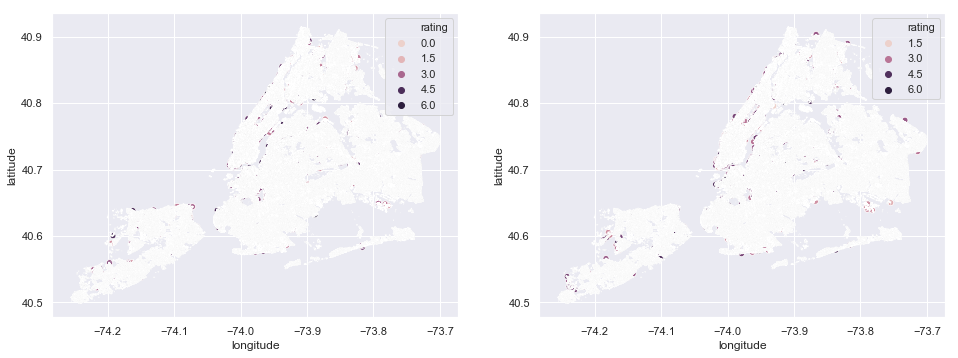

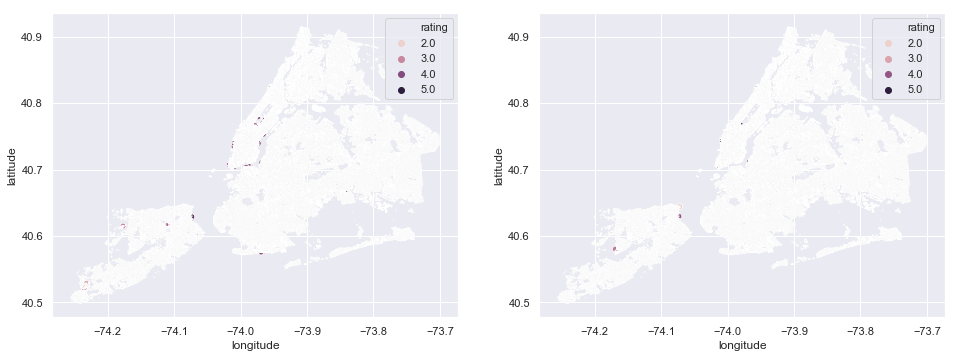

In [8]:
#I still need to fix the below visualizations; they didn't print as desired.
#Each graph will correspond to one price group (x, xx, xxx, xxxx).
#The points will show the location distribution of coffee shops for each price group.
#They will also be colored by rating so that we can get an idea of where the high-rated shops are for each price group.

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.scatterplot(x='longitude', y='latitude', ax=ax[0], hue='rating', data=shops[shops['price']=='x'])
street_map.plot(ax=ax[0], alpha=1, color='black')
sns.scatterplot(x='longitude', y='latitude', ax=ax[1], hue='rating', data=shops[shops['price']=='xx'])
street_map.plot(ax=ax[1], alpha=1, color='black')

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.scatterplot(x='longitude', y='latitude', ax=ax[0], hue='rating', data=shops[shops['price']=='xxx'])
street_map.plot(ax=ax[0], alpha=1, color='black')
sns.scatterplot(x='longitude', y='latitude', ax=ax[1], hue='rating', data=shops[shops['price']=='xxxx'])
street_map.plot(ax=ax[1], alpha=1, color='black')

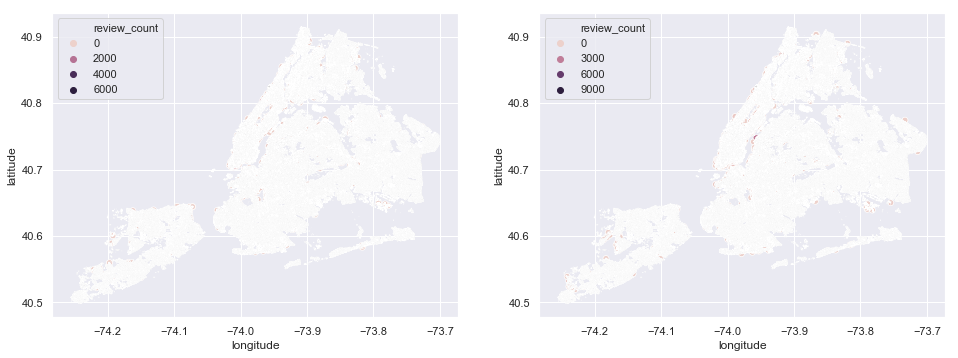

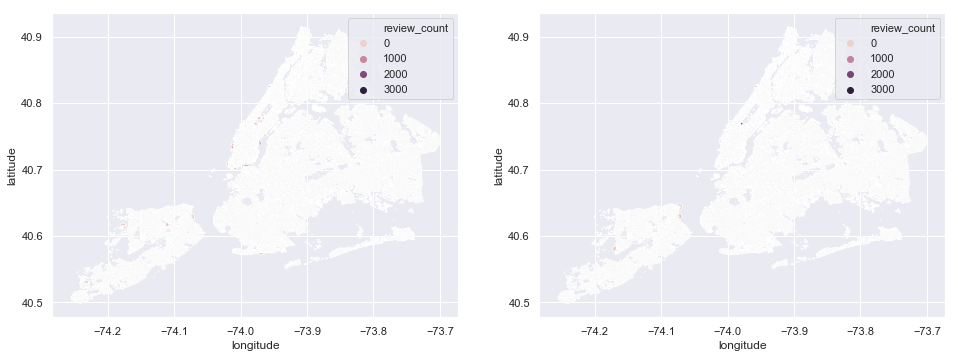

In [9]:
#I still need to fix the below visualizations; they didn't print as desired.
#Each graph will correspond to one price group (x, xx, xxx, xxxx).
#The points will show the location distribution of coffee shops for each price group.
#They will also be colored by review_count so that we can get an idea of where the high-rated shops are for each price group.

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.scatterplot(x='longitude', y='latitude', ax=ax[0], hue='review_count', data=shops[shops['price']=='x'])
street_map.plot(ax=ax[0], alpha=1, color='black')
sns.scatterplot(x='longitude', y='latitude', ax=ax[1], hue='review_count', data=shops[shops['price']=='xx'])
street_map.plot(ax=ax[1], alpha=1, color='black')

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.scatterplot(x='longitude', y='latitude', ax=ax[0], hue='review_count', data=shops[shops['price']=='xxx'])
street_map.plot(ax=ax[0], alpha=1, color='black')
sns.scatterplot(x='longitude', y='latitude', ax=ax[1], hue='review_count', data=shops[shops['price']=='xxxx'])
street_map.plot(ax=ax[1], alpha=1, color='black')


SIMULATION CODE

In [22]:
def distance(x1,y1,x2,y2):
    """Euclidean distance between (x1,y1) and (x2,y2)"""
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [23]:
def adjacencies_dictionary(df, max_distance):
    """
    This returns a dictionary whose keys are the shop_id's, and the value associated with each key is a list of shops no 
    further than max_distance away from the key, along with their distances to the key. 
    df is a dataframe with columns 'name', 'longitude' and 'latitude'. 
    """
    S = {}
    for i in range(df.shape[0]):
        longitude = df.loc[i, 'longitude']
        latitude = df.loc[i, 'latitude']
        shop_id = df.loc[i, 'shop_id']
        neighbors = []
        for j in range(df.shape[0]):
            longitude_potential_neighbor = df.loc[j, 'longitude']
            latitude_potential_neighbor = df.loc[j, 'latitude']
            distance_potential_neighbor = distance(longitude, latitude, longitude_potential_neighbor, latitude_potential_neighbor)
            if distance_potential_neighbor <= max_distance and j!=i:
                neighbor = df.loc[j, 'shop_id']
                dist = distance_potential_neighbor
                neighbors.append([neighbor, dist])
        S[shop_id] = neighbors
    return S

In [69]:
def degree_dictionary(adjacencies_dict):
    """
    This returns a dictionary whose keys are the shop id's and whose corresponding values are their degrees.
    adjacencies_dict is of the form of the output of adjacencies_dictionary().
    """
    S = {}
    for shop_id in adjacencies_dict:
        S[shop_id] = len(adjacencies_dict[shop_id])
    return S

def max_degree(adjacencies_dict):
    """
    This returns an integer.
    adjacencies_dict is of the form of the output of adjacencies_dictionary().
    """
    maximum = 0
    for shop_id in adjacencies_dict:
        if len(adjacencies_dict[shop_id]) > maximum:
            maximum = len(adjacencies_dict[shop_id])
    return maximum

def min_degree(adjacencies_dict):
    """
    This returns an integer.
    adjacencies_dict is of the form of the output of adjacencies_dictionary().
    """
    minimum = len(adjacencies_dict)
    for shop_id in adjacencies_dict:
        if len(adjacencies_dict[shop_id]) < minimum:
            minimum = len(adjacencies_dict[shop_id])
    return minimum

def avg_degree(adjacencies_dict):
    """
    This returns a float.
    adjacencies_dict is of the form of the output of adjacencies_dictionary().
    """
    degree_sum = 0
    for shop_id in adjacencies_dict:
        degree_sum += len(adjacencies_dict[shop_id])
    degree_average = degree_sum / len(adjacencies_dict)
    return degree_average

I need to decide on an apprioriate max_distance for adjacencies_dict, which defines the maximum distance two shops can be from one another and still be considered neighbors in the network. Therefore, I will try a variety of maximum distances and look at the minimum number of neighbors in the network (min_degree), the maximum number of neighbors in the network (max_degree) and the average number of neighbors in the network (avg_degree) in each case. As we can see in the following outputs, if max_distance=0.002 then then max_degree=15 and avg_degree=2.215, which is too small. On the other hand, if max_distance=0.01, then max_degree=390 and avg_degree=113, which is too large. Therefore, I will restrict 0.002<max_distance<0.01 when building the simulator and try a variety of appropriate values.

In [71]:
adjacencies1 = adjacencies_dictionary(shops, 0.001)
max_degree1 = max_degree(adjacencies1)
min_degree1 = min_degree(adjacencies1)
avg_degree1 = avg_degree(adjacencies1)
[max_degree1, min_degree1, avg_degree1]

[15, 0, 2.2153846153846155]

In [72]:
adjacencies2 = adjacencies_dictionary(shops, 0.002)
max_degree2 = max_degree(adjacencies2)
min_degree2 = min_degree(adjacencies2)
avg_degree2 = avg_degree(adjacencies2)
[max_degree2, min_degree2, avg_degree2]

[44, 0, 6.994540942928039]

In [73]:
adjacencies3 = adjacencies_dictionary(shops, 0.003)
max_degree3 = max_degree(adjacencies3)
min_degree3 = min_degree(adjacencies3)
avg_degree3 = avg_degree(adjacencies3)
[max_degree3, min_degree3, avg_degree3]

[66, 0, 13.974689826302729]

In [74]:
adjacencies4 = adjacencies_dictionary(shops, 0.005)
max_degree4 = max_degree(adjacencies4)
min_degree4 = min_degree(adjacencies4)
avg_degree4 = avg_degree(adjacencies4)
[max_degree4, min_degree4, avg_degree4]

[122, 0, 34.00322580645161]

In [75]:
adjacencies5 = adjacencies_dictionary(shops, 0.01)
max_degree5 = max_degree(adjacencies5)
min_degree5 = min_degree(adjacencies5)
avg_degree5 = avg_degree(adjacencies5)
[max_degree5, min_degree5, avg_degree5]

[390, 0, 113.00421836228288]

In [76]:
adjacencies6 = adjacencies_dictionary(shops, 0.02)
max_degree6 = max_degree(adjacencies6)
min_degree6 = min_degree(adjacencies6)
avg_degree6 = avg_degree(adjacencies6)
[max_degree6, min_degree6, avg_degree6]

[968, 0, 333.5846153846154]

In [77]:
adjacencies7 = adjacencies_dictionary(shops, 0.03)
max_degree7 = max_degree(adjacencies7)
min_degree7 = min_degree(adjacencies7)
avg_degree7 = avg_degree(adjacencies7)
[max_degree7, min_degree7, avg_degree7]

[1469, 1, 579.3538461538461]

In [78]:
adjacencies8 = adjacencies_dictionary(shops, 0.05)
max_degree8 = max_degree(adjacencies8)
min_degree8 = min_degree(adjacencies8)
avg_degree8 = avg_degree(adjacencies8)

In [79]:
adjacencies9 = adjacencies_dictionary(shops, 0.1)
max_degree9 = max_degree(adjacencies9)
min_degree9 = min_degree(adjacencies9)
avg_degree9 = avg_degree(adjacencies9)
[max_degree9, min_degree9, avg_degree9]

[3146, 24, 2274.3488833746896]

In [ ]:
#The first iteration of the trend simulator; I will gradually ramp up the complexity by incorporating probability theory and more conditions.
def trend_adoption(adjacencies_dict, iterations=0, p_x=0.1, p_xx=0.1, p_xxx=0.1, p_xxxx=0.1, seed=123):
    """
    This returns a dictionary whose keys are the shop id's and whose values are True/False depending on whether or not
    that shop has adopted the trend after the specified number of iterations.
    adjacencies_dict is in the form of the output of adjacencies_dictionary(). 
    p_x, p_xx, p_xxx, p_xxxx are the probabilities of initial adoption for price 'x', 'xx', 'xxx', 'xxxx' shops respectively.
    iterations = 1 produces only the initialization adoptions.
    seed is an optional random seed.
    """
    
    #Random initialization of trend adoption for the shops
    np.random.seed(seed)
    adoptions = {}
    for i in range(adjacencies_dict.shape[0]):
        shop_id = adjacencies_dict.loc[i, 'shop_id']
        price = adjacencies_dict.loc[i, 'price']
        if price == 'x':
            did_adopt = bool(np.random.binomial(1, p_x))
        if price == 'xx':
            did_adopt = bool(np.random.binomial(1, p_xx))
        if price == 'xxx':
            did_adopt = bool(np.random.binomial(1, p_xxx))
        if price == 'xxxx':
            did_adopt = bool(np.random.binomial(1, p_xxxx))
        adoptions[shop_id] = did_adopt
    
    #Updating the boolean values; each iteration corresponds to one update of all the of the shops
    #A shop_id has adopt=True if its initialization is True or if at least one of its neighbors has adopt=True.
    for i in range(iterations):
        for shop_id in adoptions:
            adopt = adoptions[shop_id]
            if adopt == False:
                for neighbor in adjacencies_dict[shop_id]:
                    if neighbor[0] == True:
                        adopt = True
                        break
            adoptions[shop_id] = adopt
    
    return adoptions